In [ ]:
!pip install -q gdown # Install the 'gdown' package silently (used to download files from Google Drive)
!pip install -q datasets # Install the 'datasets' package silently (from HuggingFace, used for loading datasets)

import gdown # Import the gdown module for downloading files from Google Drive via URL
import os # Import the os module for interacting with the operating system (e.g., file paths)
from collections import defaultdict # Import defaultdict from collections to initialize dictionary values automatically
from glob import glob # Import glob to search for file patterns (e.g., *.jpg, *.txt)
import matplotlib.pyplot as plt # Import matplotlib for plotting graphs or images
import numpy as np # Import numpy for numerical operations and handling arrays
import json # Import json for reading and writing JSON files
import random # Import random for generating random numbers or shuffling data
from tqdm import tqdm # Import tqdm for showing progress bars during loops
import time # Import time module to measure elapsed time or add delays
from datasets import load_dataset # Load datasets using HuggingFace's `load_dataset` utility
import shutil # Import shutil for file operations like copying, moving, or deleting files and directories

import torch # Import PyTorch (torch) for deep learning
import torchvision.transforms as transforms # Import torchvision transforms for data preprocessing (e.g., resizing, normalization)
import torchvision.models as models # Import pretrained models from torchvision
from torch.cuda.amp import autocast, GradScaler # Import autocast and GradScaler for mixed-precision training (faster, less memory)
from PIL import Image # Import PIL to handle image files (e.g., opening JPG/PNG files)
import torch.nn.functional as F # Import functional API from torch.nn for loss functions and operations like softmax
import torch.nn as nn # Import nn module for defining neural network layers and architectures
from torch.utils.data import Dataset # Import PyTorch Dataset class to create custom datasets
from torch.utils.data import DataLoader # Import DataLoader to load data in batches during training/testing
from torchvision.datasets import CIFAR100 # Import the CIFAR100 dataset from torchvision

from sklearn.model_selection import train_test_split # Import train_test_split from scikit-learn to split dataset into training and test sets
from sklearn.metrics import accuracy_score # Import accuracy_score to compute classification accuracy
from sklearn.metrics import precision_score, recall_score, f1_score, confusion_matrix, classification_report # Import common classification metrics
import seaborn as sns # Import seaborn for advanced statistical data visualization
from PIL import Image # Import PIL to handle image files (duplicate import; may be removed)


import itertools # Import itertools for creating iterators and combinations
from itertools import combinations_with_replacement # Import combinations_with_replacement to generate combinations with repetition

from google.colab import drive # Mount Google Drive to access files stored in your Drive (Colab-specific)



In [ ]:
# Load the Tiny ImageNet-200 dataset from HuggingFace's `datasets` library.
# "slegroux/tiny-imagenet-200-clean" is a cleaned version of the dataset.
dataset = load_dataset("slegroux/tiny-imagenet-200-clean")

train_data = dataset["train"] # Access the training split from the loaded dataset
val_data = dataset["validation"] # Access the validation split
test_data = dataset["test"] # Access the test split

# Print out a quick summary of the dataset splits and how many samples each contains
print(f" Loaded splits:")
print(f"  - Train: {len(train_data)} samples")    # Number of training samples
print(f"  - Validation: {len(val_data)} samples") # Number of validation samples
print(f"  - Test: {len(test_data)} samples")      # Number of test samples

 Loaded splits:
  - Train: 98179 samples
  - Validation: 4909 samples
  - Test: 4923 samples


Below is the data class used for the models to transform data into correct format

In [ ]:
# Define a custom PyTorch Dataset class for TinyImageNet dataset loaded from HuggingFace (HF)
class TinyImageNetHFDataset(Dataset):

    # Constructor method: takes in HuggingFace dataset and an optional image transform
    def __init__(self, hf_data, transform=None):
        self.data = hf_data # Store the dataset (assumed to be in HuggingFace format)
        self.transform = transform # Store the transform function (e.g., for image preprocessing)

    # Required method for PyTorch datasets: returns the number of samples
    def __len__(self):
        return len(self.data)

    # Required method for PyTorch datasets: returns one data sample (image, label) at index `idx`
    def __getitem__(self, idx):
        sample = self.data[idx]           # Get the sample at the given index
        image = sample['image']           # Extract the image from the sample
        label = sample['label']           # Extract the label from the sample
        if self.transform:                # If a transform is provided (e.g., resizing, normalization)
            image = self.transform(image) # Apply the transform to the image
        return image, label               # Return the processed image and its label

Below is Functions for comparing images for similarity used by the ConvNeXT model

In [ ]:
# Function to load and preprocess a PIL image
def load_image(pil_image):
    image = pil_image.convert("RGB")       # Convert the image to RGB mode (ensures 3 color channels)
    image = transform(image).unsqueeze(0)  # Apply image transform and add a batch dimension (1, C, H, W)
    return image                           # Return the processed image tensor

# Function to extract a feature vector from an image tensor using the given model
def get_feature_vector(img_tensor, model):
    with torch.no_grad():                              # Disable gradient calculation for inference
        features = model(img_tensor)                   # Pass image tensor through model to get features
        features = features.view(features.size(0), -1) # Flatten the feature map to a 1D vector
    return F.normalize(features)                       # Normalize the feature vector (L2 norm)

# Function to compare two images using a ConvNeXt model (or other vision backbone)
def compare_images_convnext(pil_img1, pil_img2, model, device):
    img1 = load_image(pil_img1).to(device)  # Load and move the first image to the specified device (e.g., GPU)
    img2 = load_image(pil_img2).to(device)  # Load and move the second image to the same device

    feat1 = get_feature_vector(img1, model) # Extract normalized feature vector from first image
    feat2 = get_feature_vector(img2, model) # Extract normalized feature vector from second image

    similarity = F.cosine_similarity(feat1, feat2).item() # Compute cosine similarity between the two vectors
    return similarity                       # Return the similarity score (range: -1 to 1)

Below code is the class for implementing the ArcFace Loss for each model for training

In [ ]:
# Custom loss function: ArcFace, designed to improve classification by enforcing angular margins
class ArcFaceLoss(nn.Module):
    def __init__(self, embedding_dim, num_classes, s=30.0, mi=0.5):
        super().__init__()
        self.s = s  # Scaling factor
        self.m = mi # Angular margin
        self.weight = nn.Parameter(torch.FloatTensor(num_classes, embedding_dim)) # Learnable class weights
        nn.init.xavier_uniform_(self.weight) # Initialize weights with Xavier initialization

    def forward(self, embeddings, labels):
        embeddings = F.normalize(embeddings)        # Normalize feature embeddings
        weights = F.normalize(self.weight)          # Normalize class weights
        cosine = F.linear(embeddings, weights)      # Compute cosine similarity
        theta = torch.acos(cosine.clamp(-1.0 + 1e-7, 1.0 - 1e-7)) # Compute angle (safe for arccos)
        target_logits = torch.cos(theta + self.m)   # Add margin to angle
        one_hot = torch.zeros_like(cosine)          # Create one-hot encoding
        one_hot.scatter_(1, labels.view(-1, 1), 1)  # Place 1 at correct class positions
        logits = self.s * (cosine * (1 - one_hot) + target_logits * one_hot) # Apply margin to target class only
        return F.cross_entropy(logits, labels)      # Compute cross-entropy loss

WARNING: Only use if a new model needs to be trained. Otherwise skip running this cell

This code is used to train a model using the ArcFace loss function. it will ask for access to your google drive. In order to save the model properly, adjust the drive_save_dir to the location you wish to save it. this will need to be changed for pulling the trained model in.

In [ ]:
drive.mount('/content/drive') # Mount Google Drive to access and save files from your Google account (Colab-specific)

# Define the directory in Drive where trained models will be saved
drive_save_dir = "/content/drive/MyDrive/ML.635/Final Project/Trained Models"     # will need to change based on your destination folder
os.makedirs(drive_save_dir, exist_ok=True) # Create the directory if it doesn't already exist

# Set output feature size for the model
embedding_dim = 512

# Define image preprocessing pipeline
transform = transforms.Compose([
    transforms.Resize((224, 224)),  # Resize to 224x224
    transforms.ToTensor(),          # Convert image to tensor
    transforms.Normalize(           # Normalize using ImageNet mean/std
        mean=[0.485, 0.456, 0.406],  # ImageNet normalization
        std=[0.229, 0.224, 0.225]
    )
])

# Use GPU if available, otherwise fallback to CPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Training hyperparameters
epochs = 10
batch_size = 4
""""
total range needed is .2-.6    so .65 is top end value for .6
Below m_values will need to be changed for colab timing out. recomended is to run 2 at a time
so .2-.3, .3-.4, ect.  it should look like  [round(m, 2) for m in torch.arange(0.2, 0.3, 0.05).tolist()]
"""
# Define margin values to test for ArcFace (can be run in chunks due to Colab timeout)
m_values = [round(m, 2) for m in torch.arange(0.55, 0.65, 0.05).tolist()]


# Load dataset (assumes train_dataset already defined!)
train_dataset = TinyImageNetHFDataset(train_data, transform=transform) # Wrap training data with custom dataset and apply transforms
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True) # Create DataLoader to batch and shuffle the data

# Begin training for each margin value
for m in m_values:
    model_name = f"convnext_arcface_m{m:.2f}_e{epochs}.pt" # Define model filename
    save_path = os.path.join(drive_save_dir, model_name) # Construct full save path

    if os.path.exists(save_path):
        print(f" Skipping m={m:.2f} — already saved.") # Skip training if model already saved
        continue

    print(f"\n Training model with m = {m:.2f}...") # Log which margin value is being used

    # Define model
    convnext = models.convnext_base(pretrained=True) # Load pretrained ConvNeXt model
    convnext.classifier = nn.Sequential( # Replace classifier with new head
        nn.Flatten(),
        nn.LayerNorm(1024),
        nn.Linear(1024, embedding_dim)
    )
    for param in convnext.features.parameters(): # Freeze feature extraction layers
        param.requires_grad = False
    convnext.to(device) # Move model to device

    # Loss & optimizer
    criterion = ArcFaceLoss(embedding_dim, num_classes=200, s=30.0, mi=m).to(device) # ArcFace loss with current margin
    optimizer = torch.optim.Adam(convnext.parameters(), lr=1e-4) # Adam optimizer
    scaler = GradScaler() # Enable mixed-precision training

    losses_per_epoch = [] # List to store loss per epoch
    start = time.perf_counter() # Start timer

    # Training loop
    for epoch in range(epochs):
        total_batches = len(train_loader) # Get total number of batches # Set model to training mode
        convnext.train() # Set model to training mode
        total_loss = 0 # Initialize loss for epoch

        for batch_idx, (images, labels) in enumerate(train_loader): # Iterate through data
            images, labels = images.to(device), labels.to(device) # Move data to device
            optimizer.zero_grad() # Reset gradients
            with autocast(): # Use automatic mixed precision
                embeddings = convnext(images) # Get embeddings from model
                loss = criterion(embeddings, labels)  # Compute loss
            scaler.scale(loss).backward() # Backpropagate with scaling
            scaler.step(optimizer) # Optimizer step
            scaler.update() # Update scaler
            total_loss += loss.item() # Accumulate loss
        avg = total_loss / len(train_loader) # Calculate average loss
        losses_per_epoch.append(avg)  # Store average loss
        print(f" Epoch {epoch+1}/{epochs} | m={m:.2f} | Loss: {avg:.4f}") # Print progress
        torch.cuda.empty_cache() # Clear GPU cache

    end = time.perf_counter() # Stop timer
    print(f"\n Training complete for m={m:.2f}") # Log training completion
    print(f"\nTotal training time = {(end-start)/60 :.4f} minutes") # Print training time

    # Save loss data to a JSON file
    loss_filename = f"convnext_arcface_m{m:.2f}_e{epochs}_loss.json" # Define loss filename
    loss_path = os.path.join(drive_save_dir, loss_filename)  # Construct loss file path

    with open(loss_path, "w") as f: # Write loss data to JSON file
        json.dump({
            "m_value": m,
            "epochs": epochs,
            "losses": losses_per_epoch
        }, f)

    print(f" Loss data saved to: {loss_path}") # Confirm save

    # Prepare data for plotting
    epochs_range = np.arange(1, epochs + 1) # Create range of epoch numbers
    losses_array = np.array(losses_per_epoch) # Convert list to numpy array

    poly_coeffs = np.polyfit(epochs_range, losses_array, deg=2) # Fit polynomial curve (degree 2)
    best_fit_curve = np.polyval(poly_coeffs, epochs_range) # Evaluate polynomial

    # Plot
    plt.figure(figsize=(8, 4)) # Create figure
    plt.plot(epochs_range, losses_array, 'o', label='Actual Loss', color='red')  # Plot actual loss points
    plt.plot(epochs_range, best_fit_curve, '-', label='Curve Fit', color='blue')  # Plot fitted curve
    plt.title(f"Training Loss Curve (m = {m:.2f})") # Title
    plt.xlabel("Epoch") # X label
    plt.ylabel("Loss") # Y label
    plt.grid(True, linestyle='--', linewidth=0.5) # Grid lines
    plt.legend() # Add legend

    # Save plot
    plot_path = os.path.join(drive_save_dir, f"convnext_arcface_m{m:.2f}_e{epochs}_loss.png") # Define plot path
    plt.savefig(plot_path) # Save the plot as PNG
    plt.show() # Show the plot
    plt.close() # Close the figure
    print(f" Loss plot with line of best fit saved: {plot_path}") # Confirm save

    # Save trained model
    torch.save(convnext.state_dict(), save_path) # Save model weights

    print(f" Saved: {save_path}") # Confirm model save

Loads all of the models back into Colab

In [ ]:
# Function to build the ConvNeXt model architecture with a custom output embedding size
def build_convnext_model(embedding_dim=512):
    model = models.convnext_base(pretrained=False) # Load ConvNeXt base model without pretrained weights
    model.classifier = nn.Sequential( # Replace the classifier with custom layers
        nn.Flatten(),                 # Flatten output of feature extractor
        nn.LayerNorm(1024),           # Apply LayerNorm for better convergence
        nn.Linear(1024, embedding_dim) # Final linear layer to output embedding
    )
    return model

# Function to load a trained model for a specific margin value m from disk
def load_model_by_m(m, model_dir, device, embedding_dim=512, epochs=10):
    model = build_convnext_model(embedding_dim) # Build model with specified embedding dimension
    model_path = os.path.join(model_dir, f"convnext_arcface_m{m:.2f}_e{epochs}.pt") # Construct file path

    if not os.path.exists(model_path): # Check if model file exists
        raise FileNotFoundError(f" Model not found for m={m:.2f} at: {model_path}")

    model.load_state_dict(torch.load(model_path, map_location=device)) # Load model weights
    model.to(device)  # Move model to the specified device (CPU or GPU)
    model.eval() # Set model to evaluation mode
    print(f" Loaded model for m={m:.2f}")
    return model

# Function to download a model from Google Drive and load it into memory
def download_and_load_model(m, file_ids, download_dir="/content/models", device="cpu", epochs=10):
    os.makedirs(download_dir, exist_ok=True) # Create download directory if it doesn't exist
    file_id = file_ids.get(round(m, 2)) # Get Google Drive file ID for current m
    if file_id is None:
        raise ValueError(f" No file ID found for margin m={m:.2f}")

    filename = f"convnext_arcface_m{m:.2f}_e{epochs}.pt" # Define filename
    filepath = os.path.join(download_dir, filename) # Full local file path

    if not os.path.exists(filepath): # If file not already downloaded
        url = f"https://drive.google.com/uc?id={file_id}" # Construct download URL
        print(f" Downloading model for m={m:.2f}...")
        gdown.download(url, filepath, quiet=False) # Download using gdown
    else:
        print(f" Model for m={m:.2f} already downloaded") # Skip if already downloaded

    model = build_convnext_model() # Build fresh model
    model.load_state_dict(torch.load(filepath, map_location=device)) # Load weights
    model.to(device) # Move model to device
    model.eval() # Set to eval mode
    return model


# Replace these with your actual file IDs from Google Drive
# Dictionary of Google Drive file IDs for each margin value m
model_file_ids = {
    0.20: "1m9wCAF-Vi5erD4wR6UcLtQD3J6qF_v3V",  # ID from https://drive.google.com/file/d/1A2B3C4D5E6F7G8H9/view
    0.25: "13AClnt8eMeQ9n7d1V9ABFtgySoUYm4NX",
    0.30: "1BGD3X98prXabHw7snPOH35T-3yKYTDlR",
    0.35: "15g4pSXuoXqCclfn7pXpLQjYVMLyiA4hX",
    0.40: "1-mcpt1WU8_IrEtKPYqkTBPOEWd02rx4r",
    0.45: "1-CPvFrDhZvSP80TpBTqdPVL1tmRZVWQR",
    0.50: "1-HuvBtHpYciVxOTbq-Ufk5Nx7hrAZSAb",
    0.55: "1QPkJaFkcXohAlggAGUTJSizO3RZx75Ag",
    0.60: "1g8jl1tkzIwOVrQlHzrJMhPa8DH5y92_W"
}

device = torch.device("cuda" if torch.cuda.is_available() else "cpu") # Use GPU if available
download_dir = "/content/models" # Directory to store downloaded models

# Dictionary to hold all loaded models
all_models = {}

# Loop over each margin value and load the corresponding model
for m in sorted(model_file_ids):
    model = download_and_load_model(m, model_file_ids, device=device, epochs=10) # Download and load model
    all_models[m] = model # Store in dictionary

# Print summary of loaded models
print(f" Loaded {len(all_models)} models: {list(all_models.keys())}")

 Model for m=0.20 already downloaded


/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)


 Model for m=0.25 already downloaded
 Model for m=0.30 already downloaded
 Model for m=0.35 already downloaded
 Model for m=0.40 already downloaded
 Model for m=0.45 already downloaded
 Model for m=0.50 already downloaded
 Model for m=0.55 already downloaded
 Model for m=0.60 already downloaded
 Loaded 9 models: [0.2, 0.25, 0.3, 0.35, 0.4, 0.45, 0.5, 0.55, 0.6]


Loads all models training loss/epoch data for plotting

In [ ]:
# Function to download and load the training loss log for a specific margin value m
def download_and_load_loss(m, file_ids, download_dir="/content/loss_logs", epochs=10):
    os.makedirs(download_dir, exist_ok=True) # Create the download directory if it doesn't already exist

    file_id = file_ids.get(round(m, 2)) # Retrieve the Google Drive file ID associated with the rounded margin value
    if file_id is None:
        raise ValueError(f" No file ID found for loss log m={m:.2f}") # Raise error if ID is missing

    # Construct the expected filename and full file path
    filename = f"convnext_arcface_m{m:.2f}_e{epochs}_loss.json"
    filepath = os.path.join(download_dir, filename)

    # If the file does not exist locally, download it from Google Drive
    if not os.path.exists(filepath):
        url = f"https://drive.google.com/uc?id={file_id}" # Google Drive download URL
        print(f" Downloading loss log for m={m:.2f}...")
        gdown.download(url, filepath, quiet=False) # Download the file using gdown
    else:
        print(f" Loss log for m={m:.2f} already downloaded") # Skip download if file exists

    # Load and return the loss log data from JSON file
    with open(filepath, "r") as f:
        return json.load(f) # Parse and return the contents of the JSON file


# Dictionary to store all loaded training loss logs
all_loss_logs = {}

# Dictionary mapping each margin value to its corresponding Google Drive file ID
loss_file_ids = {
    0.20: "1O3jZwoBsOlTBzLV4ouwo9bBsgz01TcXu",
    0.25: "1454Uaih_hev6NX-G7N-00hD7N4NSwxLJ",
    0.30: "1GiD0Nk3ds_Ed68mabSJrlUmWMZetMA9x",
    0.35: "12WvMID1r-P4WaqZ2vNxiQZiTdB-NTa34",
    0.40: "1ae76otFiSVFZvKqin4r4GFSfzIZG4KiY",
    0.45: "1jxQ3ye_RuW5teK7-rmNwAJE6vgKYPglz",
    0.50: "1-Cc75AHvIS4m1UL-_rmEulhVqRmfzbWF",
    0.55: "1HQBSuaSgx7pfthPrV2yb_clH05CbrS6u",
    0.60: "1zrkTGGTfnEV9w_Q6iAOZ7R4TXWNztcfM"
}

# Loop through each margin value, download and load its loss log
for m in sorted(loss_file_ids.keys()):
    loss_data = download_and_load_loss(m, loss_file_ids) # Download and parse loss JSON for each m
    all_loss_logs[m] = loss_data # Store the parsed data in the dictionary
    print(f" Loaded loss log for m={m:.2f} with {len(loss_data['losses'])} epochs.") # Print confirmation with number of epochs

 Loss log for m=0.20 already downloaded
 Loaded loss log for m=0.20 with 10 epochs.
 Loss log for m=0.25 already downloaded
 Loaded loss log for m=0.25 with 10 epochs.
 Loss log for m=0.30 already downloaded
 Loaded loss log for m=0.30 with 10 epochs.
 Loss log for m=0.35 already downloaded
 Loaded loss log for m=0.35 with 10 epochs.
 Loss log for m=0.40 already downloaded
 Loaded loss log for m=0.40 with 10 epochs.
 Loss log for m=0.45 already downloaded
 Loaded loss log for m=0.45 with 10 epochs.
 Loss log for m=0.50 already downloaded
 Loaded loss log for m=0.50 with 10 epochs.
 Loss log for m=0.55 already downloaded
 Loaded loss log for m=0.55 with 10 epochs.
 Loss log for m=0.60 already downloaded
 Loaded loss log for m=0.60 with 10 epochs.


Plots all training data on one plot

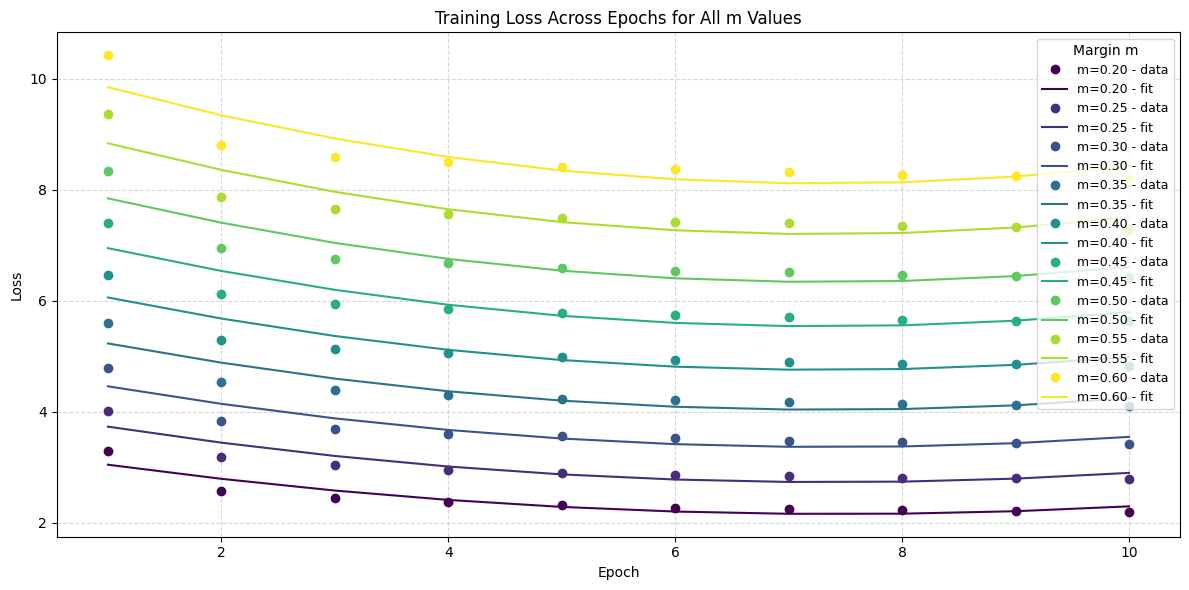

In [ ]:
# Create a new figure with a specified size (12 inches wide by 6 inches tall)
plt.figure(figsize=(12, 6))

# Generate a colormap with as many distinct colors as there are loss logs
colors = plt.cm.viridis(np.linspace(0, 1, len(all_loss_logs)))

# Get the number of epochs from the first loaded log (assumes all logs have same number of epochs)
epochs_range = np.arange(1, next(iter(all_loss_logs.values()))['epochs'] + 1)

# Loop over each margin value and its corresponding loss log
for i, (m, log) in enumerate(sorted(all_loss_logs.items())):
    losses = np.array(log["losses"]) # Convert list of loss values to a NumPy array

    # Plot the actual loss data as scatter points
    plt.plot(epochs_range, losses, 'o', color=colors[i], label=f"m={m:.2f} - data", markersize=6)

    # Fit a 2nd-degree polynomial (quadratic) to the loss data and evaluate it over the epoch range
    poly_coeffs = np.polyfit(epochs_range, losses, deg=2) # Fit the curve
    best_fit_curve = np.polyval(poly_coeffs, epochs_range) # Compute fitted values
    # Plot the curve
    plt.plot(epochs_range, best_fit_curve, linestyle='-', color=colors[i], label=f"m={m:.2f} - fit")

# Add title and axis labels
plt.title("Training Loss Across Epochs for All m Values")
plt.xlabel("Epoch")
plt.ylabel("Loss")

# Add grid for better readability
plt.grid(True, linestyle='--', alpha=0.5)

# Add legend with margin values, set location and font size
plt.legend(title="Margin m", loc="upper right", fontsize=9)

# Adjust layout to prevent label cutoff
plt.tight_layout()

# Display the plot
plt.show()

Below is the code for the ConvNeXT pretrained model

In [ ]:
# Load the ConvNeXt-Base model with pretrained weights
base_model = models.convnext_base(pretrained=True)

# Replace the model's classifier head with a custom one:
# - Flatten the output
# - Apply Layer Normalization with 1024 features
# - Add a Linear layer mapping 1024 features to 512 features
base_model.classifier = nn.Sequential(
    nn.Flatten(),
    nn.LayerNorm(1024),
    nn.Linear(1024, 512)
)

# Move the model to the specified device (e.g., GPU or CPU)
base_model.to(device)

# Set the model to evaluation mode (turns off dropout, batchnorm update, etc.)
base_model.eval()

# Store the modified model in a dictionary under the key "base"
all_models["base"] = base_model

/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ConvNeXt_Base_Weights.IMAGENET1K_V1`. You can also use `weights=ConvNeXt_Base_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Below is the function of evaluation for the models

In [ ]:
# Precompute all embeddings for the test dataset
def get_all_embeddings(model, test_data, transform, device):
    model.eval()    # Set model to evaluation mode (important for inference)
    embeddings = [] # List to store each image's embedding

    with torch.no_grad(): # Disable gradient computation for faster inference
        for sample in tqdm(test_data, desc="Embedding test images"):
            img = transform(sample["image"]).unsqueeze(0).to(device) # Apply transform, add batch dimension, move to device
            emb = model(img).squeeze(0)   # Get embedding and remove batch dimension
            emb = F.normalize(emb, dim=0) # Normalize the embedding vector to unit length
            embeddings.append(emb.cpu())  # Move embedding to CPU and store

    return torch.stack(embeddings)  # Stack all embeddings into a tensor of shape [N, D]

# Compute cosine similarity matrix between all pairs of embeddings
def get_similarity_matrix(embeddings):
    return torch.matmul(embeddings, embeddings.T)  # [N, N] matrix: cosine similarity between every pair

# Build a ground-truth label matrix: 1 if same class, 0 otherwise
def get_label_matrix(labels):
    labels = torch.tensor(labels)
    return (labels.unsqueeze(0) == labels.unsqueeze(1)).int()  # Compare all label pairs -> 1 if same, else 0

# Evaluate predictions vs ground truth over a set of thresholds
def evaluate_similarity_matrix(sim_matrix, label_matrix, thresholds):
    results = {} # Store evaluation results for each threshold
    total = len(thresholds)

    for idx, threshold in enumerate(thresholds):
        print(f"  Threshold {threshold:.2f} ({idx + 1}/{total} | {((idx + 1)/total)*100:.1f}%)")

        preds = (sim_matrix >= threshold).int().flatten().tolist() # Predict match if similarity >= threshold
        truth = label_matrix.flatten().tolist() # Ground truth labels

        # Compute metrics
        acc = accuracy_score(truth, preds)                    # Accuracy
        prec = precision_score(truth, preds, zero_division=0) # Precision
        rec = recall_score(truth, preds, zero_division=0)     # Recall
        f1 = f1_score(truth, preds, zero_division=0)          # F1 Score
        cm = confusion_matrix(truth, preds).tolist()          # Confusion matrix

        # Store metrics
        results[threshold] = {
            "accuracy": acc,
            "precision": prec,
            "recall": rec,
            "f1_score": f1,
            "confusion_matrix": cm
        }

    return results # Return results dictionary

# Full evaluation pipeline for all models
def evaluate_models_batched(models, test_data, transform, thresholds, device):
    # Extract labels from test dataset
    labels = [sample["label"] for sample in test_data]
    label_matrix = get_label_matrix(labels).to(device) # Build ground-truth similarity matrix

    all_model_results = {} # Store results for each model
    for m_val, model in models.items():
        print(f"\n Evaluating model m={m_val}")
        embeddings = get_all_embeddings(model, test_data, transform, device).to(device) # Get all embeddings
        sim_matrix = get_similarity_matrix(embeddings) # Compute similarity matrix
        model_results = evaluate_similarity_matrix(sim_matrix, label_matrix, thresholds) # Evaluate at different thresholds

        all_model_results[m_val] = model_results # Save results for this model

    return all_model_results # Return evaluation results for all models

WARNING: Below is the set up of thresholds to look at for each model. Before using this cell for testing of models at different thresholds, run the cells under it to pull in the already tested models

In [ ]:
# Create a list of thresholds from 0.30 to 0.90 (inclusive), spaced by 0.05
# Each threshold is rounded to 2 decimal places
# Example result: [0.30, 0.35, 0.40, ..., 0.90]
thresholds = [round(t, 2) for t in torch.arange(0.3, 0.95, 0.05).tolist()]  # Hyperparameter for evaluation

# Run the full evaluation over all models
# - For each model, compute embeddings
# - Compare embeddings using cosine similarity
# - Evaluate prediction metrics at each threshold
batched_results = evaluate_models_batched(all_models, test_data, transform, thresholds, device)



 Evaluating model m=0.2


Embedding test images: 100%|██████████| 4923/4923 [01:19<00:00, 62.13it/s]


  Threshold 0.30 (1/13 | 7.7%)
  Threshold 0.35 (2/13 | 15.4%)
  Threshold 0.40 (3/13 | 23.1%)
  Threshold 0.45 (4/13 | 30.8%)
  Threshold 0.50 (5/13 | 38.5%)
  Threshold 0.55 (6/13 | 46.2%)
  Threshold 0.60 (7/13 | 53.8%)
  Threshold 0.65 (8/13 | 61.5%)
  Threshold 0.70 (9/13 | 69.2%)
  Threshold 0.75 (10/13 | 76.9%)
  Threshold 0.80 (11/13 | 84.6%)
  Threshold 0.85 (12/13 | 92.3%)
  Threshold 0.90 (13/13 | 100.0%)

 Evaluating model m=0.25


Embedding test images: 100%|██████████| 4923/4923 [01:18<00:00, 62.58it/s]


  Threshold 0.30 (1/13 | 7.7%)
  Threshold 0.35 (2/13 | 15.4%)
  Threshold 0.40 (3/13 | 23.1%)
  Threshold 0.45 (4/13 | 30.8%)
  Threshold 0.50 (5/13 | 38.5%)
  Threshold 0.55 (6/13 | 46.2%)
  Threshold 0.60 (7/13 | 53.8%)
  Threshold 0.65 (8/13 | 61.5%)
  Threshold 0.70 (9/13 | 69.2%)
  Threshold 0.75 (10/13 | 76.9%)
  Threshold 0.80 (11/13 | 84.6%)
  Threshold 0.85 (12/13 | 92.3%)
  Threshold 0.90 (13/13 | 100.0%)

 Evaluating model m=0.3


Embedding test images: 100%|██████████| 4923/4923 [01:20<00:00, 61.25it/s]


  Threshold 0.30 (1/13 | 7.7%)
  Threshold 0.35 (2/13 | 15.4%)
  Threshold 0.40 (3/13 | 23.1%)
  Threshold 0.45 (4/13 | 30.8%)
  Threshold 0.50 (5/13 | 38.5%)
  Threshold 0.55 (6/13 | 46.2%)
  Threshold 0.60 (7/13 | 53.8%)
  Threshold 0.65 (8/13 | 61.5%)
  Threshold 0.70 (9/13 | 69.2%)
  Threshold 0.75 (10/13 | 76.9%)
  Threshold 0.80 (11/13 | 84.6%)
  Threshold 0.85 (12/13 | 92.3%)
  Threshold 0.90 (13/13 | 100.0%)

 Evaluating model m=0.35


Embedding test images: 100%|██████████| 4923/4923 [01:17<00:00, 63.45it/s]


  Threshold 0.30 (1/13 | 7.7%)
  Threshold 0.35 (2/13 | 15.4%)
  Threshold 0.40 (3/13 | 23.1%)
  Threshold 0.45 (4/13 | 30.8%)
  Threshold 0.50 (5/13 | 38.5%)
  Threshold 0.55 (6/13 | 46.2%)
  Threshold 0.60 (7/13 | 53.8%)
  Threshold 0.65 (8/13 | 61.5%)
  Threshold 0.70 (9/13 | 69.2%)
  Threshold 0.75 (10/13 | 76.9%)
  Threshold 0.80 (11/13 | 84.6%)
  Threshold 0.85 (12/13 | 92.3%)
  Threshold 0.90 (13/13 | 100.0%)

 Evaluating model m=0.4


Embedding test images: 100%|██████████| 4923/4923 [01:20<00:00, 61.06it/s]


  Threshold 0.30 (1/13 | 7.7%)
  Threshold 0.35 (2/13 | 15.4%)
  Threshold 0.40 (3/13 | 23.1%)
  Threshold 0.45 (4/13 | 30.8%)
  Threshold 0.50 (5/13 | 38.5%)
  Threshold 0.55 (6/13 | 46.2%)
  Threshold 0.60 (7/13 | 53.8%)
  Threshold 0.65 (8/13 | 61.5%)
  Threshold 0.70 (9/13 | 69.2%)
  Threshold 0.75 (10/13 | 76.9%)
  Threshold 0.80 (11/13 | 84.6%)
  Threshold 0.85 (12/13 | 92.3%)
  Threshold 0.90 (13/13 | 100.0%)

 Evaluating model m=0.45


Embedding test images: 100%|██████████| 4923/4923 [01:20<00:00, 60.78it/s]


  Threshold 0.30 (1/13 | 7.7%)
  Threshold 0.35 (2/13 | 15.4%)
  Threshold 0.40 (3/13 | 23.1%)
  Threshold 0.45 (4/13 | 30.8%)
  Threshold 0.50 (5/13 | 38.5%)
  Threshold 0.55 (6/13 | 46.2%)
  Threshold 0.60 (7/13 | 53.8%)
  Threshold 0.65 (8/13 | 61.5%)
  Threshold 0.70 (9/13 | 69.2%)
  Threshold 0.75 (10/13 | 76.9%)
  Threshold 0.80 (11/13 | 84.6%)
  Threshold 0.85 (12/13 | 92.3%)
  Threshold 0.90 (13/13 | 100.0%)

 Evaluating model m=0.5


Embedding test images: 100%|██████████| 4923/4923 [01:20<00:00, 60.86it/s]


  Threshold 0.30 (1/13 | 7.7%)
  Threshold 0.35 (2/13 | 15.4%)
  Threshold 0.40 (3/13 | 23.1%)
  Threshold 0.45 (4/13 | 30.8%)
  Threshold 0.50 (5/13 | 38.5%)
  Threshold 0.55 (6/13 | 46.2%)
  Threshold 0.60 (7/13 | 53.8%)
  Threshold 0.65 (8/13 | 61.5%)
  Threshold 0.70 (9/13 | 69.2%)
  Threshold 0.75 (10/13 | 76.9%)
  Threshold 0.80 (11/13 | 84.6%)
  Threshold 0.85 (12/13 | 92.3%)
  Threshold 0.90 (13/13 | 100.0%)

 Evaluating model m=0.55


Embedding test images: 100%|██████████| 4923/4923 [01:20<00:00, 61.04it/s]


  Threshold 0.30 (1/13 | 7.7%)
  Threshold 0.35 (2/13 | 15.4%)
  Threshold 0.40 (3/13 | 23.1%)
  Threshold 0.45 (4/13 | 30.8%)
  Threshold 0.50 (5/13 | 38.5%)
  Threshold 0.55 (6/13 | 46.2%)
  Threshold 0.60 (7/13 | 53.8%)
  Threshold 0.65 (8/13 | 61.5%)
  Threshold 0.70 (9/13 | 69.2%)
  Threshold 0.75 (10/13 | 76.9%)
  Threshold 0.80 (11/13 | 84.6%)
  Threshold 0.85 (12/13 | 92.3%)
  Threshold 0.90 (13/13 | 100.0%)

 Evaluating model m=0.6


Embedding test images: 100%|██████████| 4923/4923 [01:21<00:00, 60.62it/s]


  Threshold 0.30 (1/13 | 7.7%)
  Threshold 0.35 (2/13 | 15.4%)
  Threshold 0.40 (3/13 | 23.1%)
  Threshold 0.45 (4/13 | 30.8%)
  Threshold 0.50 (5/13 | 38.5%)
  Threshold 0.55 (6/13 | 46.2%)
  Threshold 0.60 (7/13 | 53.8%)
  Threshold 0.65 (8/13 | 61.5%)
  Threshold 0.70 (9/13 | 69.2%)
  Threshold 0.75 (10/13 | 76.9%)
  Threshold 0.80 (11/13 | 84.6%)
  Threshold 0.85 (12/13 | 92.3%)
  Threshold 0.90 (13/13 | 100.0%)

 Evaluating model m=base


Embedding test images: 100%|██████████| 4923/4923 [01:21<00:00, 60.73it/s]


  Threshold 0.30 (1/13 | 7.7%)
  Threshold 0.35 (2/13 | 15.4%)
  Threshold 0.40 (3/13 | 23.1%)
  Threshold 0.45 (4/13 | 30.8%)
  Threshold 0.50 (5/13 | 38.5%)
  Threshold 0.55 (6/13 | 46.2%)
  Threshold 0.60 (7/13 | 53.8%)
  Threshold 0.65 (8/13 | 61.5%)
  Threshold 0.70 (9/13 | 69.2%)
  Threshold 0.75 (10/13 | 76.9%)
  Threshold 0.80 (11/13 | 84.6%)
  Threshold 0.85 (12/13 | 92.3%)
  Threshold 0.90 (13/13 | 100.0%)


Below is the code to pull in the saved results of tested models at different thresholds

In [ ]:
# Google Drive file ID for the JSON results file
file_id = "1QdIYstS_95zzZPWS-qMBz8mvq3YHojI4"

# Directory where the downloaded file will be saved
# (Should be the same location where models are stored)
download_dir = "/content/drive/MyDrive/ML.635/Final Project/Trained Models"
os.makedirs(download_dir, exist_ok=True) # Create the directory if it doesn't exist

# Define the full path and filename for the JSON file
filename = "tested_models_results.json"
file_path = os.path.join(download_dir, filename)

# Check if the file already exists locally
if not os.path.exists(file_path):
    # If not, download the file from Google Drive
    url = f"https://drive.google.com/uc?id={file_id}"
    print(" Downloading tested results JSON...")
    gdown.download(url, file_path, quiet=False)
else:
    # If already exists, skip download
    print(" File already exists.")

# Load the JSON file contents into the batched_results dictionary
with open(file_path, "r") as f:
    batched_results = json.load(f)

print(" Successfully loaded batched results!")

 File already exists.
 Successfully loaded batched results!


Below prints the results of the models as well as the best performing model

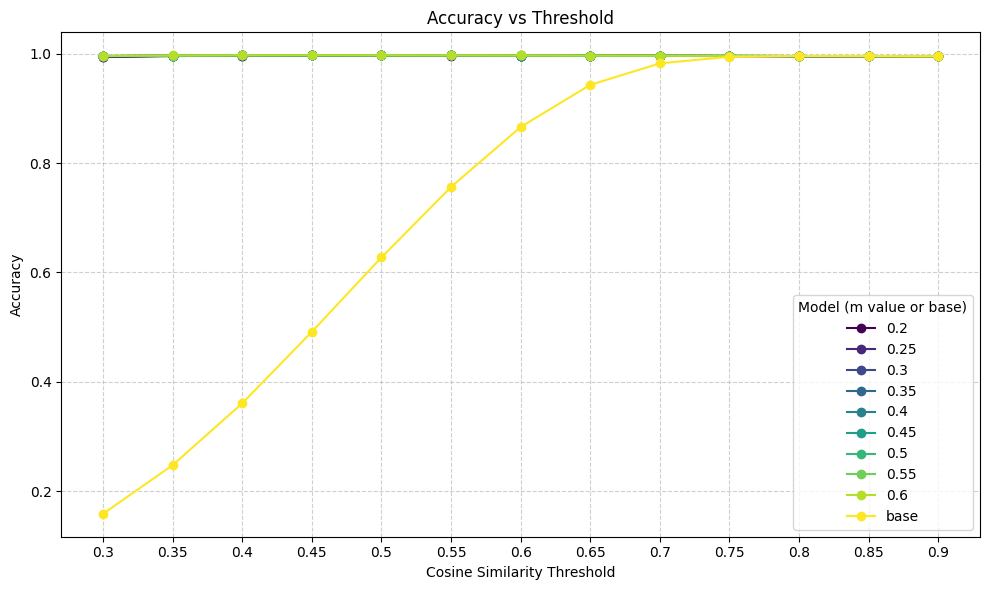

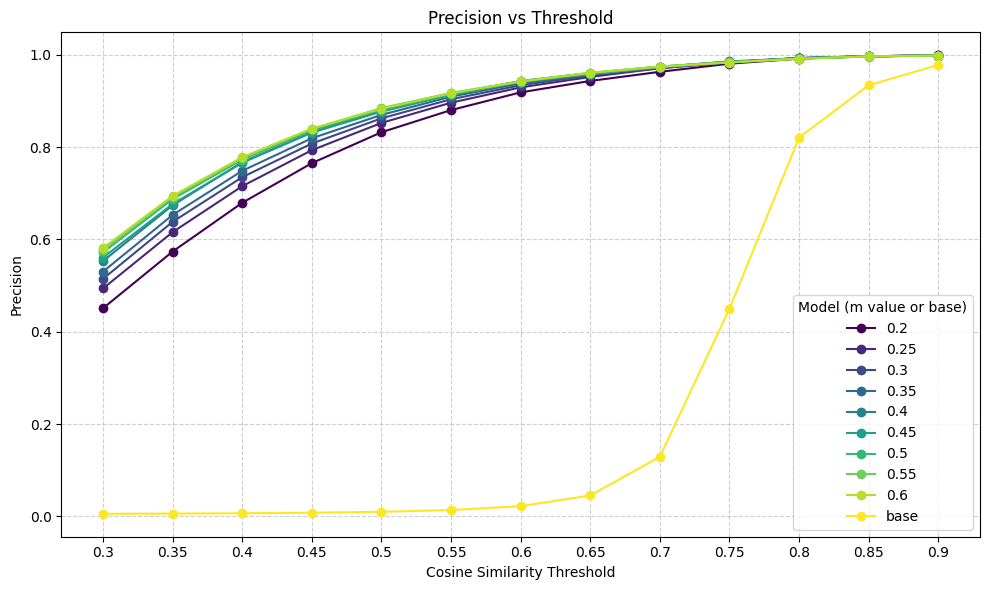

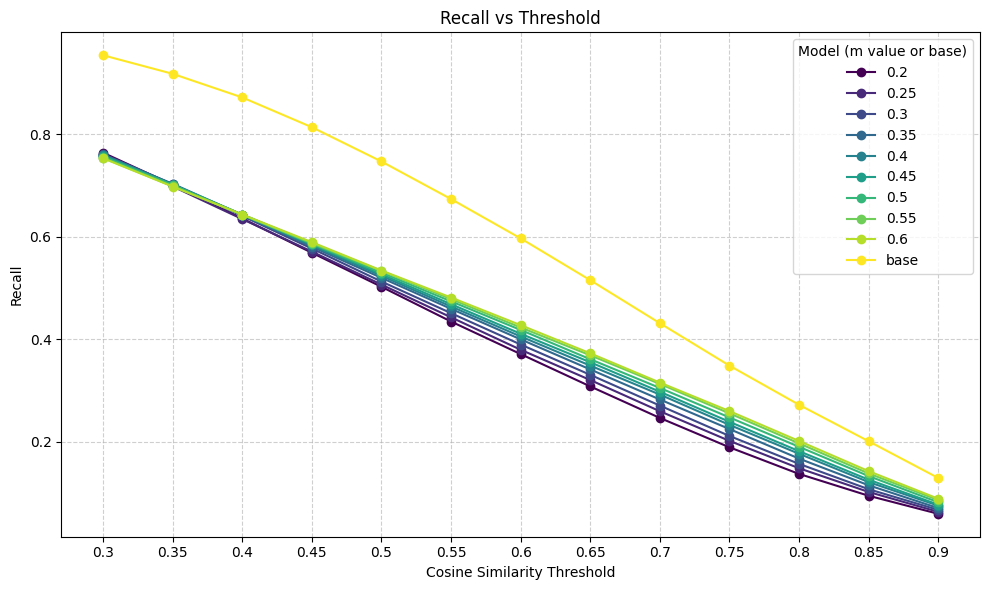

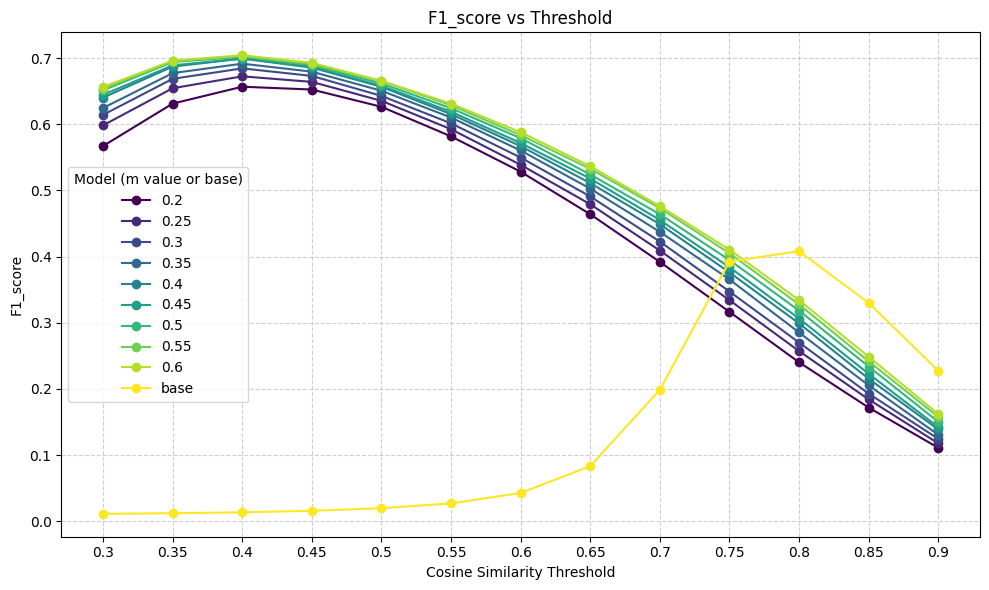


 Top 5 Models by Accuracy:
1. Model: 0.6, Threshold: 0.45, Accuracy: 99.7385%
2. Model: 0.55, Threshold: 0.45, Accuracy: 99.7373%
3. Model: 0.5, Threshold: 0.45, Accuracy: 99.7356%
4. Model: 0.45, Threshold: 0.45, Accuracy: 99.7331%
5. Model: 0.4, Threshold: 0.45, Accuracy: 99.7326%

 Best Model by Accuracy
  Model: 0.6
  Threshold: 0.45
  Accuracy: 0.9974

 Worst Model by Accuracy (excluding base)
  Model: 0.2
  Threshold: 0.30
  Accuracy: 0.9942

 Best Base Model Performance
  Threshold: 0.80
  Accuracy: 0.9961

 Best Model by F1 Score
  Model: 0.6
  Threshold: 0.40
  F1 Score: 0.7044


In [ ]:
# Define which evaluation metrics to plot
metrics = ['accuracy', 'precision', 'recall', 'f1_score']

# Create a color palette for plotting (one color per model)
colors = plt.cm.viridis(np.linspace(0, 1, len(batched_results)))

# Plot each selected metric separately
for metric in metrics:
    plt.figure(figsize=(10, 6)) # Create a new figure for each metric
    for i, (model_label, threshold_data) in enumerate(sorted(batched_results.items(), key=lambda x: str(x[0]))):
        thresholds_sorted = sorted(threshold_data.keys()) # Sort thresholds
        values = [threshold_data[t][metric] for t in thresholds_sorted] # Extract metric values for plotting

        plt.plot(thresholds_sorted, values, label=str(model_label), color=colors[i], marker='o') # Plot curve for each model

    # Configure plot details
    plt.title(f"{metric.capitalize()} vs Threshold")
    plt.xlabel("Cosine Similarity Threshold")
    plt.ylabel(metric.capitalize())
    plt.grid(True, linestyle='--', alpha=0.6)
    plt.legend(title="Model (m value or base)")
    plt.tight_layout()
    plt.show()

# Identify best model by F1

# Initialize trackers for best and worst models
best_model = None
best_threshold = None
best_f1 = -1 # Track highest F1 score

best_acc_model = None
best_acc_threshold = None
best_accuracy = -1 # Track highest accuracy

worst_acc_model = None
worst_acc_threshold = None
worst_accuracy = float('inf') # Track lowest accuracy (excluding "base" model)

base_best_acc = -1 # Track best accuracy specifically for "base" model
base_best_thresh = None

top_accuracy_scores = [] # Track all accuracy scores for ranking

# Loop through all models and thresholds to find best/worst performances
for model_label, threshold_data in batched_results.items():
    for t, scores in threshold_data.items():
        acc = scores["accuracy"]
        f1 = scores["f1_score"]

        # Update best F1 score tracking
        if f1 > best_f1:
            best_f1 = f1
            best_model = model_label
            best_threshold = t

        # Update best accuracy tracking
        if acc > best_accuracy:
            best_accuracy = acc
            best_acc_model = model_label
            best_acc_threshold = t

        # Update worst accuracy tracking (excluding base model)
        if model_label != "base" and acc < worst_accuracy:
            worst_accuracy = acc
            worst_acc_model = model_label
            worst_acc_threshold = t

        # Track best accuracy for the "base" model
        if model_label == "base" and acc > base_best_acc:
            base_best_acc = acc
            base_best_thresh = t

        # Store all accuracy scores for final top-5 sorting
        top_accuracy_scores.append({
            "model": model_label,
            "threshold": t,
            "accuracy": acc
        })

# Sort models by accuracy descending
top_accuracy_scores.sort(key=lambda x: x["accuracy"], reverse=True)
# Print top 5 models by accuracy
print("\n Top 5 Models by Accuracy:")
for i, entry in enumerate(top_accuracy_scores[:5], 1):
    print(f"{i}. Model: {entry['model']}, Threshold: {float(entry['threshold']):.2f}, Accuracy: {entry['accuracy'] * 100:.4f}%")

# Print best model by overall accuracy
print("\n Best Model by Accuracy")
print(f"  Model: {best_acc_model}")
print(f"  Threshold: {float(best_acc_threshold):.2f}")
print(f"  Accuracy: {best_accuracy:.4f}")

# Print worst model by accuracy (excluding base model)
print("\n Worst Model by Accuracy (excluding base)")
print(f"  Model: {worst_acc_model}")
print(f"  Threshold: {float(worst_acc_threshold):.2f}")
print(f"  Accuracy: {worst_accuracy:.4f}")

# Print best performance specifically for the base model
print("\n Best Base Model Performance")
print(f"  Threshold: {float(base_best_thresh):.2f}")
print(f"  Accuracy: {base_best_acc:.4f}")

# Print best model by F1 score
print("\n Best Model by F1 Score")
print(f"  Model: {best_model}")
print(f"  Threshold: {float(best_threshold):.2f}")
print(f"  F1 Score: {best_f1:.4f}")

WARNING: DO not use the cell below unless a new best model and worst model is being looked at for training data results                               

The below cell trains a new best and worst model to analyze the percison, F1, Recall, and loss versus epoch over trainin


 Best Model: m=0.6 | Threshold=0.45
 Worst Model: m=0.2 | Threshold=0.30

 Training Model (WORST_M_0.20)


/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ConvNeXt_Base_Weights.IMAGENET1K_V1`. You can also use `weights=ConvNeXt_Base_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
<ipython-input-29-371272c79332>:96: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = GradScaler()
<ipython-input-29-371272c79332>:109: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():


 Epoch 1/10 | Acc: 0.0017 | Prec: 0.0018 | Rec: 0.0007 | F1: 0.0009 | Loss: 3.2865


<ipython-input-29-371272c79332>:109: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():


 Epoch 2/10 | Acc: 0.0013 | Prec: 0.0013 | Rec: 0.0005 | F1: 0.0007 | Loss: 2.5613


<ipython-input-29-371272c79332>:109: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():


 Epoch 3/10 | Acc: 0.0014 | Prec: 0.0014 | Rec: 0.0006 | F1: 0.0008 | Loss: 2.4245


<ipython-input-29-371272c79332>:109: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():


 Epoch 4/10 | Acc: 0.0015 | Prec: 0.0015 | Rec: 0.0006 | F1: 0.0008 | Loss: 2.3586


<ipython-input-29-371272c79332>:109: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():


 Epoch 5/10 | Acc: 0.0015 | Prec: 0.0016 | Rec: 0.0006 | F1: 0.0008 | Loss: 2.2975


<ipython-input-29-371272c79332>:109: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():


 Epoch 6/10 | Acc: 0.0015 | Prec: 0.0015 | Rec: 0.0006 | F1: 0.0008 | Loss: 2.2736


<ipython-input-29-371272c79332>:109: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():


 Epoch 7/10 | Acc: 0.0017 | Prec: 0.0017 | Rec: 0.0007 | F1: 0.0009 | Loss: 2.2437


<ipython-input-29-371272c79332>:109: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():


 Epoch 8/10 | Acc: 0.0013 | Prec: 0.0013 | Rec: 0.0005 | F1: 0.0007 | Loss: 2.2152


<ipython-input-29-371272c79332>:109: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():


 Epoch 9/10 | Acc: 0.0013 | Prec: 0.0014 | Rec: 0.0005 | F1: 0.0007 | Loss: 2.2041


<ipython-input-29-371272c79332>:109: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():


 Epoch 10/10 | Acc: 0.0014 | Prec: 0.0017 | Rec: 0.0006 | F1: 0.0008 | Loss: 2.1893
 Model saved: /content/drive/MyDrive/ML.635/Final Project/Retrained Models/retrain_worst_m_0.20_arcface_m0.20_e10.pt
 Metrics saved: /content/drive/MyDrive/ML.635/Final Project/Retrained Models/worst_m_0.20_metrics.json


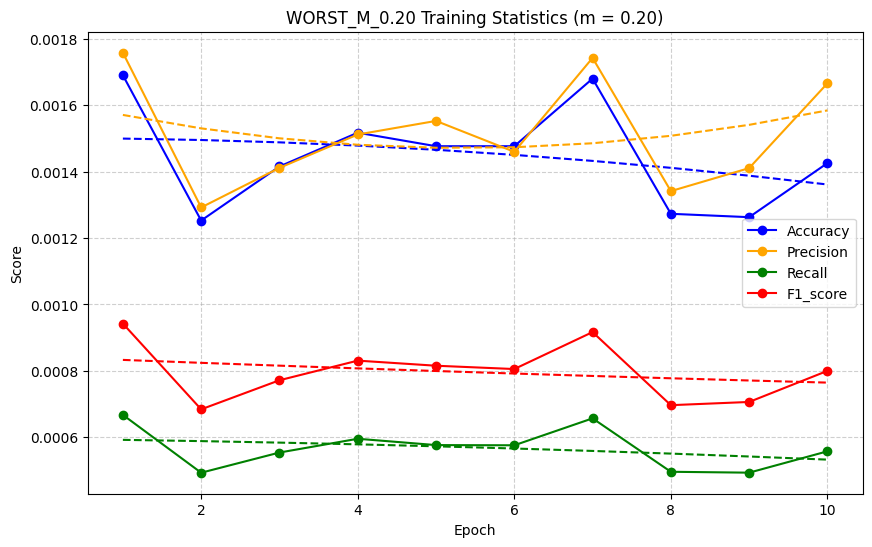

 Plot saved: /content/drive/MyDrive/ML.635/Final Project/Retrained Models/worst_m_0.20_metrics_plot.png


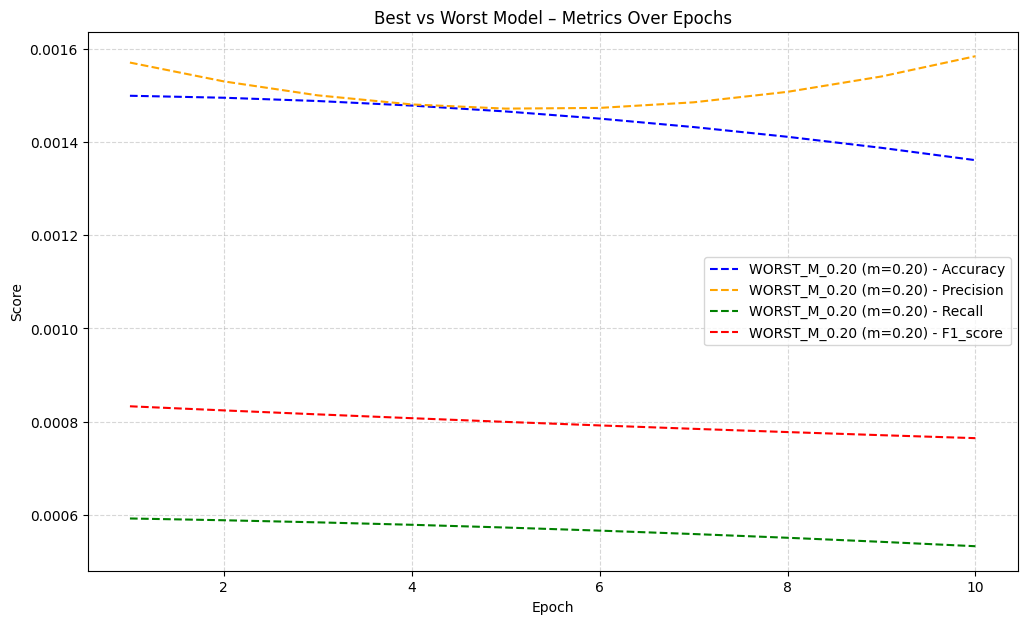

 Combined plot saved to: /content/drive/MyDrive/ML.635/Final Project/Retrained Models/best_vs_worst_combined_metrics.png


In [ ]:
# ----------------------------------------------------------------------------------
# Setup directories and environment
# ----------------------------------------------------------------------------------

# (Optional) Remove the /content/drive folder if it exists to avoid re-mounting errors
# if os.path.exists("/content/drive"):
#     shutil.rmtree("/content/drive")

# Define directory where retrained models will be saved
drive_save_dir = "/content/drive/MyDrive/ML.635/Final Project/Retrained Models"

# (Optional) Create directory if it doesn't exist
# os.makedirs(drive_save_dir, exist_ok=True)

# Force re-mount Google Drive to avoid "already contains files" error
# drive.mount("/content/drive", force_remount=True)

# Define base project directory for saving model retraining results
drive_base_dir = "/content/drive/MyDrive"
project_dir = os.path.join(drive_base_dir, "ML.635/Final Project/Model Retrain Results")

# Create the project directory if it doesn't exist
os.makedirs(project_dir, exist_ok=True)


# ----------------------------------------------------------------------------------
# Prepare color mapping for plots (if needed later)
colors_by_metric = {
    "accuracy": "blue",
    "precision": "orange",
    "recall": "green",
    "f1_score": "red",
    "loss": "purple"
}

# ----------------------------------------------------------------------------------
# Identify Best and Worst Models based on Accuracy
# ----------------------------------------------------------------------------------
top_accuracy_scores = []

# Loop through batched evaluation results
for model_label, threshold_data in batched_results.items():
    if model_label == "base":
        continue # Skip base model

    for t, scores in threshold_data.items():
        top_accuracy_scores.append({
            "model": model_label,
            "threshold": t,
            "accuracy": scores["accuracy"]
        })

# Sort models by accuracy descending
top_accuracy_scores.sort(key=lambda x: x["accuracy"], reverse=True)

# Pick the best and worst models
best_model_info = top_accuracy_scores[0]
worst_model_info = top_accuracy_scores[-1]

# Extract model values
best_acc_model = float(best_model_info["model"])
best_acc_threshold = best_model_info["threshold"]
worst_model = float(worst_model_info["model"])
worst_threshold = worst_model_info["threshold"]

# Print best and worst models
print(f"\n Best Model: m={best_acc_model} | Threshold={float(best_acc_threshold):.2f}")
print(f" Worst Model: m={worst_model} | Threshold={float(worst_threshold):.2f}")

# ----------------------------------------------------------------------------------
# Define models to retrain
# ----------------------------------------------------------------------------------

models_to_train = {
    # Uncomment to retrain best model too
    # f"best_m_{best_acc_model:.2f}": best_acc_model,
    f"worst_m_{worst_model:.2f}": worst_model
}

# Dictionary to store training histories
all_histories = {}

# ----------------------------------------------------------------------------------
# Define data transformations and load training data
# ----------------------------------------------------------------------------------

# Standard ImageNet preprocessing for ConvNeXt
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(
        mean=[0.485, 0.456, 0.406], # ImageNet mean
        std=[0.229, 0.224, 0.225].  # ImageNet std
    )
])

# Training parameters
epochs = 10
embedding_dim = 512
batch_size = 4

# Load dataset with defined transform
train_dataset = TinyImageNetHFDataset(train_data, transform=transform)
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

# ----------------------------------------------------------------------------------
# Retrain each selected model
# ----------------------------------------------------------------------------------

for label, m in models_to_train.items():
    print(f"\n Training Model ({label.upper()})")

    # Define save path for the model
    model_name = f"retrain_{label}_arcface_m{m:.2f}_e{epochs}.pt"
    save_path = os.path.join(drive_save_dir, model_name)

    # Initialize ConvNeXt model
    convnext = models.convnext_base(pretrained=True)
    convnext.classifier = nn.Sequential(
        nn.Flatten(),
        nn.LayerNorm(1024),
        nn.Linear(1024, 512)
    )

    # Freeze feature extractor layers (train only classifier)
    for param in convnext.features.parameters():
        param.requires_grad = False
    convnext.to(device)

    # Define ArcFace loss with specific margin 'm'
    criterion = ArcFaceLoss(embedding_dim, num_classes=200, s=30.0, mi=m).to(device)

    # Optimizer and mixed-precision scaler
    optimizer = torch.optim.Adam(convnext.parameters(), lr=1e-4)
    scaler = GradScaler()

    # Initialize history dictionary
    history = {k: [] for k in ["accuracy", "precision", "recall", "f1_score", "loss"]}
    epochs = 10

    # ------------------------------------------------------
    # Epoch loop
    for epoch in range(epochs):
        convnext.train()
        epoch_preds, epoch_labels = [], []
        total_loss = 0

        # Mini-batch loop
        for images, labels in train_loader:
            images, labels = images.to(device), labels.to(device)
            optimizer.zero_grad()
            with autocast():
                embeddings = convnext(images)
                loss = criterion(embeddings, labels)
            scaler.scale(loss).backward()
            scaler.step(optimizer)
            scaler.update()

            total_loss += loss.item()
            preds = torch.argmax(embeddings, dim=1)
            epoch_preds.extend(preds.cpu().numpy())
            epoch_labels.extend(labels.cpu().numpy())

        # Calculate metrics for the epoch
        acc = accuracy_score(epoch_labels, epoch_preds)
        prec = precision_score(epoch_labels, epoch_preds, average='macro', zero_division=0)
        rec = recall_score(epoch_labels, epoch_preds, average='macro', zero_division=0)
        f1 = f1_score(epoch_labels, epoch_preds, average='macro', zero_division=0)
        avg_loss = total_loss / len(train_loader)

        # Save epoch metrics to history
        history["accuracy"].append(acc)
        history["precision"].append(prec)
        history["recall"].append(rec)
        history["f1_score"].append(f1)
        history["loss"].append(avg_loss)

        print(f" Epoch {epoch+1}/{epochs} | Acc: {acc:.4f} | Prec: {prec:.4f} | Rec: {rec:.4f} | F1: {f1:.4f} | Loss: {avg_loss:.4f}")

    # Save model weights
    all_histories[label] = history

    torch.save(convnext.state_dict(), save_path)
    print(f" Model saved: {save_path}")

    # Save training metrics as JSON
    metrics_path = os.path.join(drive_save_dir, f"{label}_metrics.json")
    with open(metrics_path, "w") as f:
        json.dump(history, f)
    print(f" Metrics saved: {metrics_path}")

Below cell pulls and prints the best and worst model trained results metrics

 Metrics for best_m_0.60 already downloaded.
 Metrics for worst_m_0.20 already downloaded.


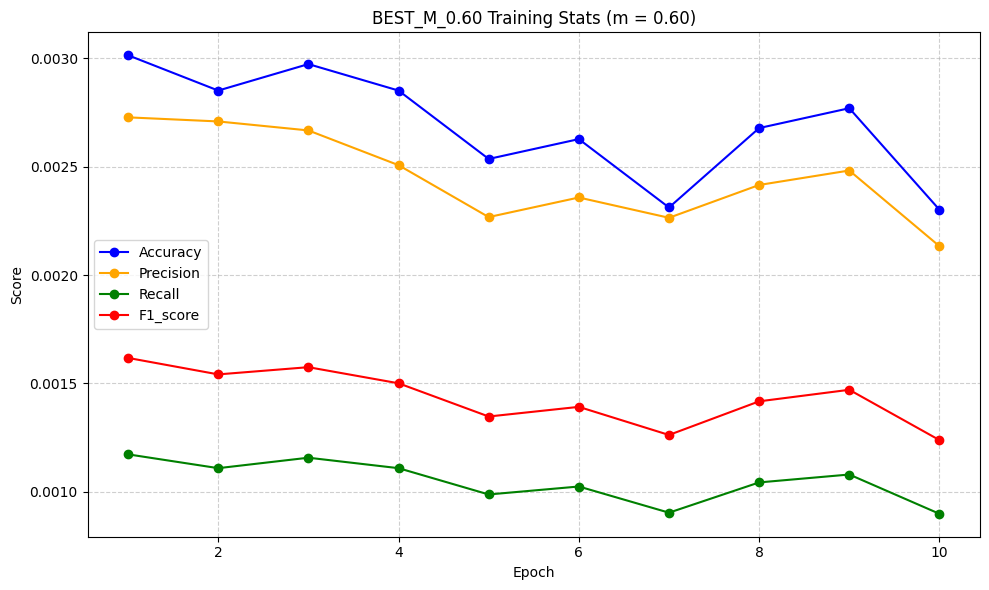

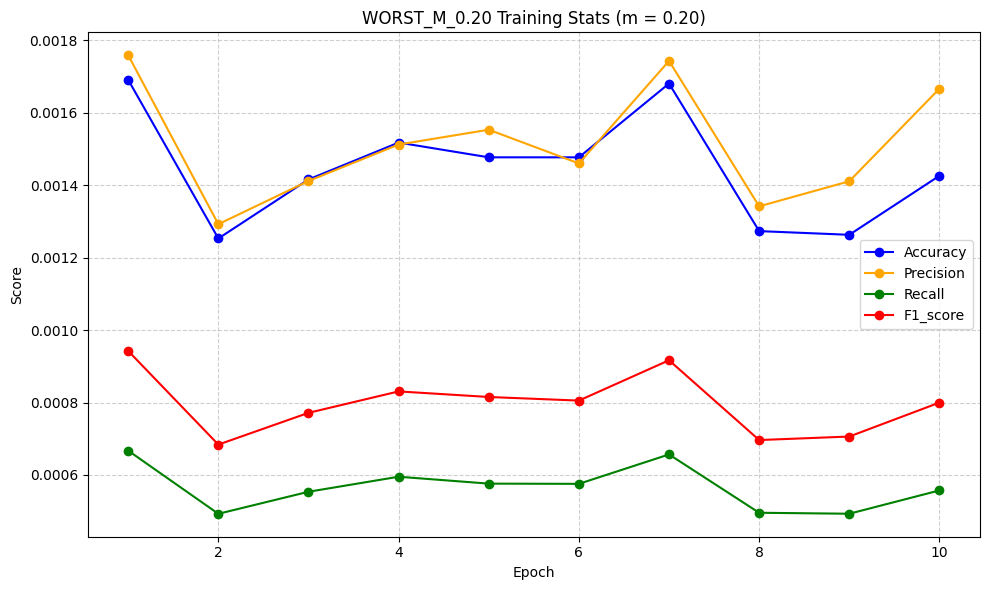

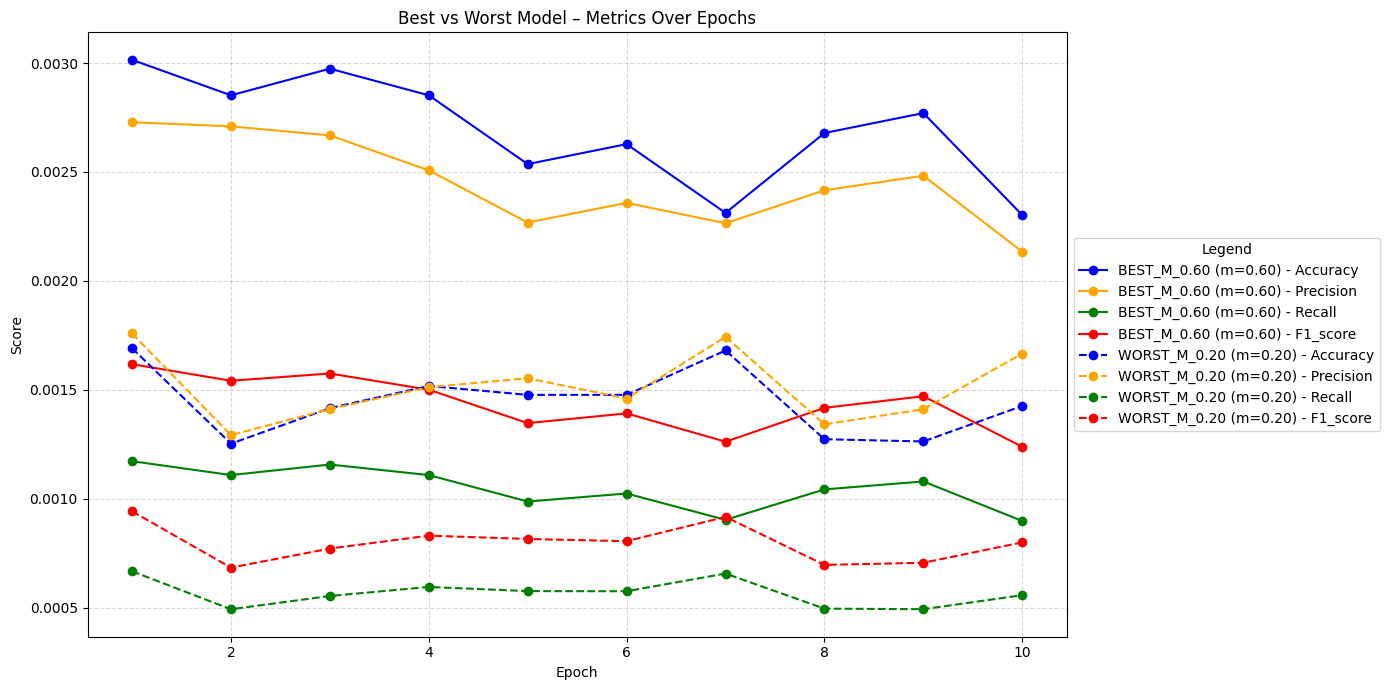

In [ ]:
# ------------------------------------------------------------------------
# Function to download and load retrained model metrics from Google Drive
# ------------------------------------------------------------------------
def download_and_load_metrics(label, file_ids, download_dir="/content/retrain_metrics", filename=None):
    os.makedirs(download_dir, exist_ok=True) # Create directory if it doesn't exist

    file_id = file_ids.get(label) # Get the Google Drive file ID for the given label
    if file_id is None:
        raise ValueError(f" No file ID found for label: {label}")

    # If filename is not specified, build a default filename
    if filename is None:
        filename = f"retrain_{label}_metrics.json"

    file_path = os.path.join(download_dir, filename)

    # Download the file if it does not exist already
    if not os.path.exists(file_path):
        url = f"https://drive.google.com/uc?id={file_id}"
        print(f" Downloading metrics for: {label}")
        gdown.download(url, file_path, quiet=False)
    else:
        print(f" Metrics for {label} already downloaded.")

    # Load and return the metrics from JSON file
    with open(file_path, "r") as f:
        return json.load(f)

# ------------------------------------------------------------------------
# Define mapping from model labels to their corresponding Google Drive file IDs
# ------------------------------------------------------------------------
metric_file_ids = {
    "best_m_0.60": "1UgRwgxpTYxfO8Y1g8zuPwPJw8cidVsQa",
    "worst_m_0.20": "1MBk_Lw5KCySw-CZjQ0hqJ-sZ-e_1wBNO"
}

# Initialize dictionary to store all retrained model metrics
all_retrain_metrics = {}

# Download and load metrics for each retrained model
for label in metric_file_ids:
    all_retrain_metrics[label] = download_and_load_metrics(label, metric_file_ids)


# ------------------------------------------------------------------------
# Define color mapping for each evaluation metric for plotting clarity
# ------------------------------------------------------------------------
colors_by_metric = {
    "accuracy": "blue",
    "precision": "orange",
    "recall": "green",
    "f1_score": "red"
}

# ------------------------------------------------------------------------
# Plot INDIVIDUAL metric curves for each model
# ------------------------------------------------------------------------
for label, history in all_retrain_metrics.items():
    plt.figure(figsize=(10, 6))
    x = np.arange(1, len(history["accuracy"]) + 1) # x-axis: epochs
    m_val = label.split("_")[-1] # Extract 'm' value from label

    # Plot each metric curve separately (accuracy, precision, recall, f1)
    for key in ["accuracy", "precision", "recall", "f1_score"]:
        y = np.array(history[key])
        plt.plot(x, y, 'o-', label=key.capitalize(), color=colors_by_metric[key])  # Dots + solid line

    plt.title(f"{label.upper()} Training Stats (m = {m_val})")
    plt.xlabel("Epoch")
    plt.ylabel("Score")
    plt.grid(True, linestyle="--", alpha=0.6)
    plt.legend()
    plt.tight_layout()
    plt.show()



# ------------------------------------------------------------------------
# Plot COMBINED curves: Compare Best and Worst models together
# ------------------------------------------------------------------------
plt.figure(figsize=(14, 7))  # Wider figure for combined plot
x = np.arange(1, len(next(iter(all_retrain_metrics.values()))["accuracy"]) + 1) # x-axis: epochs

for label, history in all_retrain_metrics.items():
    m_val = label.split("_")[-1]
    for key in ["accuracy", "precision", "recall", "f1_score"]:
        y = np.array(history[key])

        # Use solid line for best model, dashed line for worst model
        linestyle = '-' if "best" in label else '--'
        plt.plot(x, y, linestyle=linestyle, marker='o',
                 label=f"{label.upper()} (m={m_val}) - {key.capitalize()}",
                 color=colors_by_metric[key])

# Final plot formatting
plt.title("Best vs Worst Model – Metrics Over Epochs")
plt.xlabel("Epoch")
plt.ylabel("Score")
plt.grid(True, linestyle="--", alpha=0.5)

# Move legend outside the plot for better visibility
plt.legend(loc="center left", bbox_to_anchor=(1, 0.5), title="Legend", frameon=True)
plt.tight_layout()
plt.show()

Below prints a Bar graph of the best, worst, and base model results after obtaining training results

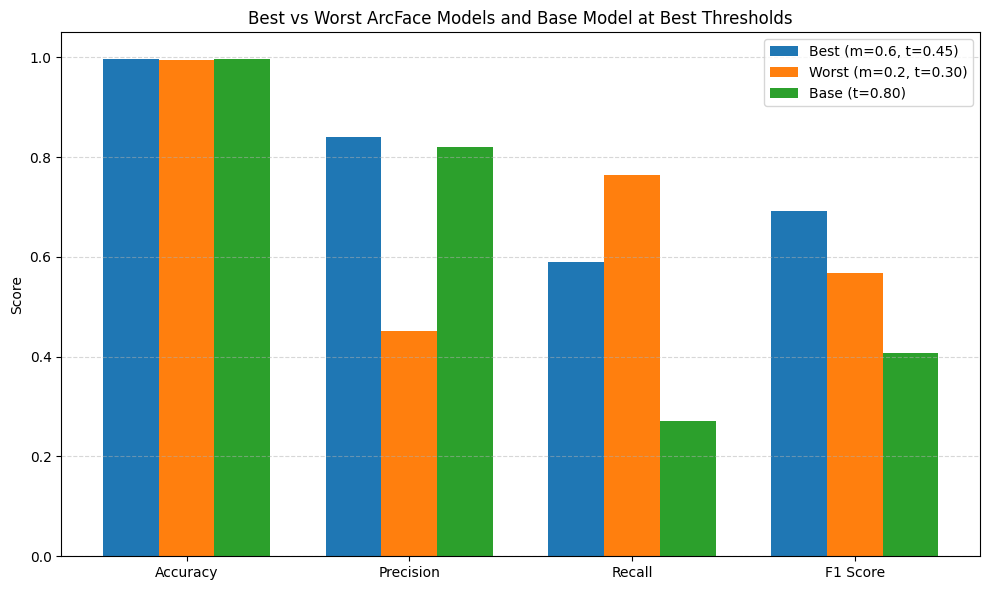

In [ ]:
# ------------------------------------------------------------------------
# Identify base model key ("base" or "Base" depending on naming)
# ------------------------------------------------------------------------
base_model_key = "base" if "base" in batched_results else "Base"

# ------------------------------------------------------------------------
# Retrieve best model performance (already identified earlier)
# ------------------------------------------------------------------------
best_scores = batched_results[best_acc_model][best_acc_threshold]

# ------------------------------------------------------------------------
# Find the worst performing model (excluding the base model)
# ------------------------------------------------------------------------
worst_acc = 1.0 # Initialize with highest possible accuracy
worst_model = None
worst_threshold = None

# Loop through all models and thresholds
for model_label, threshold_data in batched_results.items():
    if model_label == base_model_key:
        continue  # Skip base model

    for t, scores in threshold_data.items():
        if scores["accuracy"] < worst_acc: # Look for the lowest accuracy
            worst_acc = scores["accuracy"]
            worst_model = model_label
            worst_threshold = t

# Get performance scores for the worst model
worst_scores = batched_results[worst_model][worst_threshold]

# ------------------------------------------------------------------------
# Find the best performance of the base model
# ------------------------------------------------------------------------
base_best_acc = -1 # Initialize with lowest accuracy
base_best_thresh = None

# Loop through all thresholds for base model
for t, scores in batched_results[base_model_key].items():
    if scores["accuracy"] > base_best_acc:  # Look for highest base model accuracy
        base_best_acc = scores["accuracy"]
        base_best_thresh = t

# Get the base model's best scores
base_scores = batched_results[base_model_key][base_best_thresh]

# ------------------------------------------------------------------------
# Prepare data for bar chart comparison
# ------------------------------------------------------------------------

# Define labels for metrics
labels = ['Accuracy', 'Precision', 'Recall', 'F1 Score']
x = range(len(labels)) # x-axis positions

# Organize scores for best, worst, and base models
data = {
    f"Best (m={best_acc_model}, t={float(best_acc_threshold):.2f})": [best_scores[m] for m in ['accuracy', 'precision', 'recall', 'f1_score']],
    f"Worst (m={worst_model}, t={float(worst_threshold):.2f})": [worst_scores[m] for m in ['accuracy', 'precision', 'recall', 'f1_score']],
    f"Base (t={float(base_best_thresh):.2f})": [base_scores[m] for m in ['accuracy', 'precision', 'recall', 'f1_score']]
}

# Define bar width and offsets for multiple groups
bar_width = 0.25
offsets = [-bar_width, 0, bar_width]

# ------------------------------------------------------------------------
# Plotting bar chart comparison
# ------------------------------------------------------------------------

plt.figure(figsize=(10, 6))

# Draw a bar for each model category (best, worst, base)
for i, (label, scores) in enumerate(data.items()):
    plt.bar([p + offsets[i] for p in x], scores, width=bar_width, label=label)

# Format the plot
plt.xticks(ticks=x, labels=labels)
plt.title("Best vs Worst ArcFace Models and Base Model at Best Thresholds")
plt.ylabel("Score")
plt.ylim(0, 1.05) # Set y-axis limit slightly above 1
plt.grid(axis='y', linestyle='--', alpha=0.5) # Light grid for better readability
plt.legend()
plt.tight_layout()
plt.show()

Below prints the confusion matrix

In [ ]:
# ------------------------------------------------------------------------
# Loop through all models and their corresponding evaluation thresholds
# ------------------------------------------------------------------------
for m_val, thresholds in sorted(batched_results.items(), key=lambda x: str(x[0])):

    # Format the model label nicely:
    # If the model value (m_val) is a float, format it with two decimals
    # Otherwise, just use its string representation
    label_str = f"m={m_val:.2f}" if isinstance(m_val, float) else str(m_val)

    # Print header for the current model
    print(f"\n Confusion Matrices for Model {label_str}")
    print("-" * 60)

    # Loop through all thresholds for this model, sorted numerically
    for threshold in sorted(thresholds.keys(), key=lambda x: float(x)):
        cm = thresholds[threshold]['confusion_matrix'] # Retrieve confusion matrix

        # Print threshold information
        print(f"Threshold = {float(threshold):.2f}")
        print("Confusion Matrix [TN, FP], [FN, TP]:")

        # Nicely print confusion matrix as two rows
        print(f"{cm[0]}\n{cm[1]}")
        print("-" * 40)



 Confusion Matrices for Model 0.2
------------------------------------------------------------
Threshold = 0.30
Confusion Matrix [TN, FP], [FN, TP]:
[24001770, 112888]
[28576, 92695]
----------------------------------------
Threshold = 0.35
Confusion Matrix [TN, FP], [FN, TP]:
[24051434, 63224]
[36172, 85099]
----------------------------------------
Threshold = 0.40
Confusion Matrix [TN, FP], [FN, TP]:
[24078260, 36398]
[44166, 77105]
----------------------------------------
Threshold = 0.45
Confusion Matrix [TN, FP], [FN, TP]:
[24093488, 21170]
[52282, 68989]
----------------------------------------
Threshold = 0.50
Confusion Matrix [TN, FP], [FN, TP]:
[24102366, 12292]
[60350, 60921]
----------------------------------------
Threshold = 0.55
Confusion Matrix [TN, FP], [FN, TP]:
[24107482, 7176]
[68582, 52689]
----------------------------------------
Threshold = 0.60
Confusion Matrix [TN, FP], [FN, TP]:
[24110668, 3990]
[76296, 44975]
----------------------------------------
Threshold

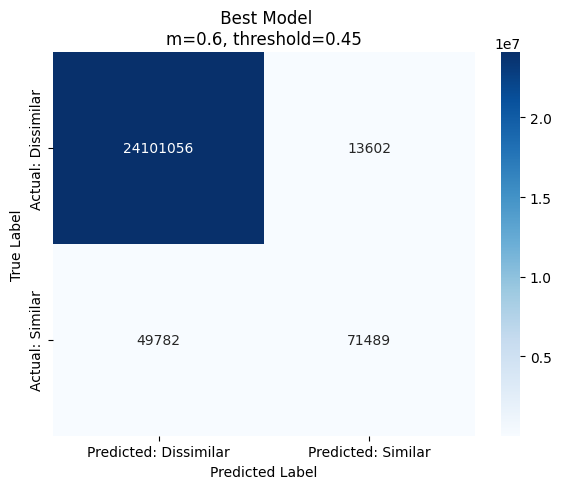

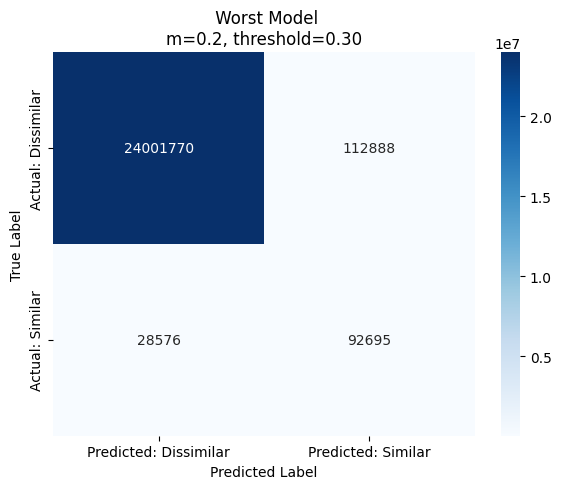

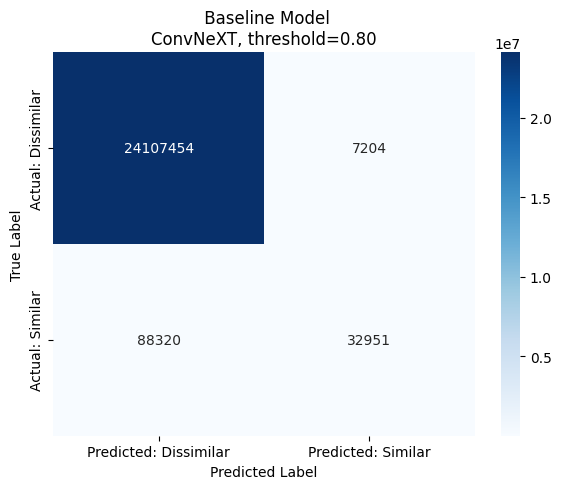

In [ ]:
# ------------------------------------------------------------------------
# Function to plot a confusion matrix using a heatmap
# ------------------------------------------------------------------------
def plot_confusion_matrix(cm, title):
    plt.figure(figsize=(6, 5)) # Set figure size
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=True, # Plot the confusion matrix as a heatmap
                xticklabels=["Predicted: Dissimilar", "Predicted: Similar"], # X-axis labels
                yticklabels=["Actual: Dissimilar", "Actual: Similar"])       # Y-axis labels
    plt.title(title)       # Set the plot title
    plt.xlabel("Predicted Label")  # X-axis label
    plt.ylabel("True Label")       # Y-axis label
    plt.tight_layout().    # Adjust layout for better fit
    plt.show()             # Display the plot

# ------------------------------------------------------------------------
# Retrieve the confusion matrices for:
# 1. Best model (highest accuracy)
# 2. Worst model (lowest accuracy excluding base)
# 3. Base model (best performance among thresholds)
# ------------------------------------------------------------------------
best_cm = batched_results[best_acc_model][best_acc_threshold]["confusion_matrix"]
worst_cm = batched_results[worst_model][worst_threshold]["confusion_matrix"]
base_cm = batched_results[base_model_key][base_best_thresh]["confusion_matrix"]

# ------------------------------------------------------------------------
# Plot confusion matrices for each model
# ------------------------------------------------------------------------

# Plot best model confusion matrix
plot_confusion_matrix(best_cm, f" Best Model\nm={best_acc_model}, threshold={float(best_acc_threshold):.2f}")

# Plot worst model confusion matrix
plot_confusion_matrix(worst_cm, f" Worst Model\nm={worst_model}, threshold={float(worst_threshold):.2f}")

# Plot base model confusion matrix
plot_confusion_matrix(base_cm, f" Baseline Model\nConvNeXT, threshold={float(base_best_thresh):.2f}")

WARNING: only use to add results to google drive. Do no operate if results are already in drive or pulled in earlier

In [ ]:
# ------------------------------------------------------------------------
# Define the path where evaluation results will be saved
# ------------------------------------------------------------------------
results_save_path = "/content/drive/MyDrive/ML.635/Final Project/Trained Models/tested_models_results.json"

# ------------------------------------------------------------------------
# Save the batched evaluation results into a JSON file
# ------------------------------------------------------------------------
with open(results_save_path, "w") as f:
    json.dump(batched_results, f) # Serialize and save the batched_results dictionary

# Confirm save success
print(f" Results saved to: {results_save_path}")

 Results saved to: /content/drive/MyDrive/ML.635/Final Project/Trained Models/tested_models_results.json


The below cells are used for testing to see if our models are overfitted. TO do this, a new dataset is used with unique classes but similar style and format of images. The best performing model on Tiny ImageNet will be tested for similarity of paris of images on the CIFAR-100 dataset

The below block pulls in the data of the CIFAR-100 dataset for testing if the model is overfititng or not

In [ ]:
# ------------------------------------------------------------------------
# Define the image preprocessing transform (same as used for TinyImageNet)
# ------------------------------------------------------------------------
transform = transforms.Compose([
    transforms.Resize((224, 224)),    # Resize images to 224x224
    transforms.ToTensor(),            # Convert images to PyTorch tensors
    transforms.Normalize(             # Normalize images using ImageNet mean and std
        mean=[0.485, 0.456, 0.406],
        std=[0.229, 0.224, 0.225]
    )
])

# ------------------------------------------------------------------------
# Load the CIFAR-100 test dataset (raw, without any transform yet)
# ------------------------------------------------------------------------
cifar100_raw = CIFAR100(root="/content/data", train=False, download=True)

# ------------------------------------------------------------------------
# Convert CIFAR-100 dataset into a HuggingFace-style format (list of dictionaries)
# Each entry will have:
# - "image": the raw PIL image
# - "label": the ground-truth class label
# ------------------------------------------------------------------------
hf_cifar100_test = []
for i in range(len(cifar100_raw)):
    img, label = cifar100_raw[i]
    hf_cifar100_test.append({
        "image": img,
        "label": label
    })

The cell below tests the best model at the best threhsold for accuracy, f1, recall, percision on the CIFAR-100 dataset

In [ ]:
# ------------------------------------------------------------------------
# Select a small subset of CIFAR-100 to reduce computation time
# ------------------------------------------------------------------------
num_limit = 300 # Limit to first 300 samples
test_data = hf_cifar100_test[:num_limit]
labels = [sample["label"] for sample in test_data] # Extract labels for the subset

# ------------------------------------------------------------------------
# Generate all possible (i, j) pairs with replacement
# (i.e., (i, i), (i, j), (j, i), etc. — no duplicate (i, j) and (j, i))
# Each pair is labeled 1 if they belong to the same class, otherwise 0
# ------------------------------------------------------------------------
from itertools import combinations_with_replacement

pairs = list(combinations_with_replacement(range(len(test_data)), 2))
test_pairs = [(i, j, int(labels[i] == labels[j])) for i, j in pairs]

# ------------------------------------------------------------------------
# Load pretrained ConvNeXt model with ArcFace head
# ------------------------------------------------------------------------

m = 0.60             # ArcFace margin value used during training
threshold = 0.45     # Similarity threshold for deciding "same class" prediction
model_path = f"/content/models/convnext_arcface_m{m:.2f}_e10.pt"
model = build_convnext_model() # Build model architecture (you must have defined this function separately)
model.load_state_dict(torch.load(model_path, map_location=device)) # Load saved model weights
model.to(device)
model.eval() # Set model to evaluation mode

# ------------------------------------------------------------------------
# Compare all pairs and make similarity predictions
# ------------------------------------------------------------------------

true_labels, predictions = [], [] # Initialize lists to store true and predicted labels

for i, j, label in tqdm(test_pairs, desc="Evaluating CIFAR-100 Pairs"):
    # Transform and prepare two images
    img1 = transform(test_data[i]['image']).unsqueeze(0).to(device) # Add batch dimension
    img2 = transform(test_data[j]['image']).unsqueeze(0).to(device)

    with torch.no_grad(): # No gradient calculation needed for inference
        emb1 = F.normalize(model(img1).squeeze(0), dim=0) # Get normalized embedding of img1
        emb2 = F.normalize(model(img2).squeeze(0), dim=0) # Get normalized embedding of img2
        sim = F.cosine_similarity(emb1.unsqueeze(0), emb2.unsqueeze(0)).item()  # Cosine similarity between embeddings

    # Predict "similar" if similarity >= threshold, else "dissimilar"
    pred = 1 if sim >= threshold else 0

    # Store the ground truth and prediction
    true_labels.append(label)
    predictions.append(pred)

# ------------------------------------------------------------------------
# Calculate and print evaluation metrics
# ------------------------------------------------------------------------

acc = accuracy_score(true_labels, predictions)
prec = precision_score(true_labels, predictions, zero_division=0)
rec = recall_score(true_labels, predictions, zero_division=0)
f1 = f1_score(true_labels, predictions, zero_division=0)
cm = confusion_matrix(true_labels, predictions)

# Print metrics
print(f"Accuracy:  {acc:.4f}")
print(f"Precision: {prec:.4f}")
print(f"Recall:    {rec:.4f}")
print(f"F1 Score:  {f1:.4f}")
print("Confusion Matrix:\n", cm)

/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)
Evaluating CIFAR-100 Pairs: 100%|██████████| 45150/45150 [24:45<00:00, 30.40it/s]


Accuracy:  0.9907
Precision: 0.8032
Recall:    0.5557
F1 Score:  0.6569
Confusion Matrix:
 [[44324    99]
 [  323   404]]


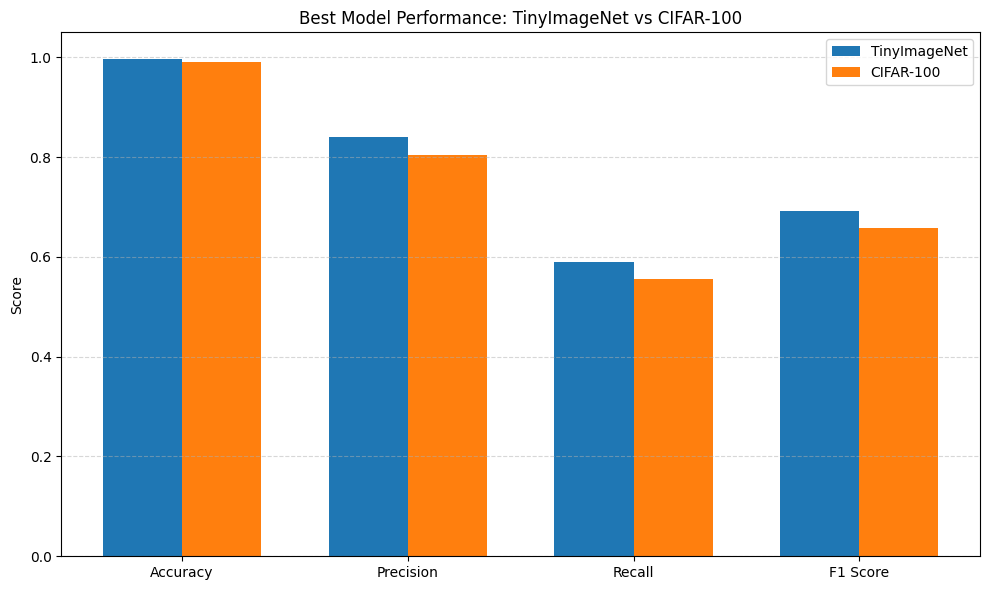

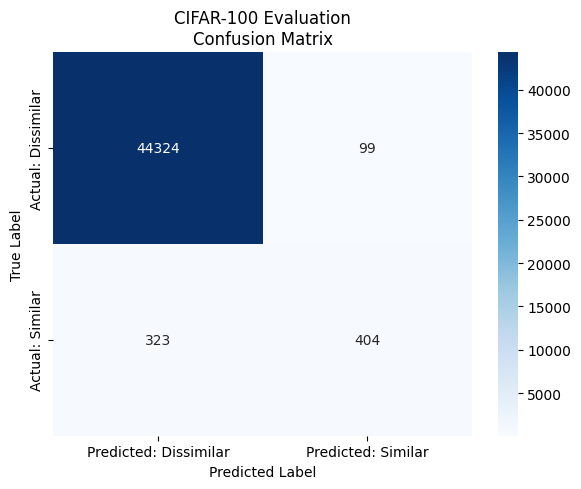

In [ ]:
# ------------------------------------------------------------------------
# Prepare TinyImageNet evaluation scores (best model, best threshold)
# ------------------------------------------------------------------------
tinyimagenet_scores = {
    "Accuracy": batched_results[best_acc_model][best_acc_threshold]["accuracy"],
    "Precision": batched_results[best_acc_model][best_acc_threshold]["precision"],
    "Recall": batched_results[best_acc_model][best_acc_threshold]["recall"],
    "F1 Score": batched_results[best_acc_model][best_acc_threshold]["f1_score"]
}

# ------------------------------------------------------------------------
# Prepare CIFAR-100 evaluation scores (previously computed)
# ------------------------------------------------------------------------
cifar_scores = {
    "Accuracy": acc,
    "Precision": prec,
    "Recall": rec,
    "F1 Score": f1
}

# ------------------------------------------------------------------------
# Create a side-by-side bar graph comparing TinyImageNet and CIFAR-100 performance
# ------------------------------------------------------------------------

labels = list(tinyimagenet_scores.keys()) # Metric names
x = np.arange(len(labels))                # X-axis positions
width = 0.35                              # Width of each bar

plt.figure(figsize=(10, 6))

# Plot TinyImageNet scores
bars1 = plt.bar(x - width/2, [tinyimagenet_scores[m] for m in labels], width, label='TinyImageNet')

# Plot CIFAR-100 scores
bars2 = plt.bar(x + width/2, [cifar_scores[m] for m in labels], width, label='CIFAR-100')


# ------------------------------------------------------------------------
# Final plot formatting
# ------------------------------------------------------------------------

plt.ylabel('Score')
plt.title('Best Model Performance: TinyImageNet vs CIFAR-100')
plt.xticks(x, labels)
plt.ylim(0, 1.05) # Y-axis from 0 to slightly above 1
plt.legend()
plt.grid(axis='y', linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()

# ------------------------------------------------------------------------
# Define a helper function to plot confusion matrix as a heatmap
# ------------------------------------------------------------------------
def plot_confusion_matrix(cm, title):
    plt.figure(figsize=(6, 5))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=True,
                xticklabels=["Predicted: Dissimilar", "Predicted: Similar"],
                yticklabels=["Actual: Dissimilar", "Actual: Similar"])
    plt.title(title)
    plt.xlabel("Predicted Label")
    plt.ylabel("True Label")
    plt.tight_layout()
    plt.show()

# ------------------------------------------------------------------------
# Plot the confusion matrix for CIFAR-100 evaluation
# ------------------------------------------------------------------------
plot_confusion_matrix(cm, title="CIFAR-100 Evaluation\nConfusion Matrix")

# **References**

# **Datasets**
Tiny ImageNet-200
Slegroux, S. (2023). tiny-imagenet-200-clean. Hugging Face Datasets. URL: https://huggingface.co/datasets/slegroux/tiny-imagenet-200-clean

CIFAR-100
Krizhevsky, A., & Hinton, G. (2009). Learning multiple layers of features from tiny images. Technical Report. URL: https://www.cs.toronto.edu/~kriz/cifar.html

# **Models and Architectures**
ConvNeXt
Liu, Z., Mao, H., Wu, C., Feichtenhofer, C., Darrell, T., & Xie, S. (2022). A ConvNet for the 2020s. Proceedings of the IEEE/CVF Conference on Computer Vision and Pattern Recognition. URL: https://arxiv.org/abs/2201.03545
(Pytorch Implementation: torchvision.models.convnext_base)

# **Loss Functions**
ArcFace Loss
Deng, J., Guo, J., & Zafeiriou, S. (2019). ArcFace: Additive Angular Margin Loss for Deep Face Recognition. Proceedings of the IEEE/CVF Conference on Computer Vision and Pattern Recognition. URL: https://arxiv.org/abs/1801.07698

# **Libraries and Tools**
PyTorch
Paszke, A., Gross, S., Massa, F., Lerer, A., Bradbury, J., Chanan, G., ... & Chintala, S. (2019). PyTorch: An Imperative Style, High-Performance Deep Learning Library. Advances in Neural Information Processing Systems (NeurIPS). URL: https://pytorch.org/

Torchvision
Torchvision: Datasets, Transforms, and Models specific to Computer Vision. URL: https://pytorch.org/vision/stable/index.html
(Version used: e.g., 0.15.2 — update as appropriate)

NumPy
Harris, C. R., Millman, K. J., van der Walt, S. J., Gommers, R., Virtanen, P., Cournapeau, D., ... & Oliphant, T. E. (2020). Array programming with NumPy. Nature, 585(7825), 357–362. URL: https://numpy.org/

Matplotlib
Hunter, J. D. (2007). Matplotlib: A 2D Graphics Environment. Computing in Science & Engineering, 9(3), 90–95. URL: https://matplotlib.org/

Seaborn
Waskom, M. L. (2021). Seaborn: Statistical Data Visualization. Journal of Open Source Software, 6(60), 3021. URL: https://seaborn.pydata.org/

Scikit-learn
Pedregosa, F., Varoquaux, G., Gramfort, A., Michel, V., Thirion, B., Grisel, O., ... & Duchesnay, É. (2011). Scikit-learn: Machine Learning in Python. Journal of Machine Learning Research, 12, 2825–2830. URL: https://scikit-learn.org/

gdown (for Google Drive downloads)
gdown: Download a large file from Google Drive. GitHub Repository. URL: https://github.com/wkentaro/gdown

datasets (Hugging Face)
Wolf, T., Debut, L., Sanh, V., Chaumond, J., Delangue, C., Moi, A., ... & Rush, A. M. (2020). Transformers: State-of-the-Art Natural Language Processing. In Proceedings of the 2020 Conference on Empirical Methods in Natural Language Processing: System Demonstrations. URL: https://huggingface.co/docs/datasets

tqdm
Da Costa-Luis, C. (2019). tqdm: A Fast, Extensible Progress Bar for Python and CLI. Journal of Open Source Software, 4(37), 1277. URL: https://github.com/tqdm/tqdm